# Gogle Colab Set up

In [ ]:
!git clone https://github.com/Juanki0396/TFG

In [ ]:
import os
os.chdir("TFG")

In [ ]:
!pip install -r requirements.txt
!bash dataset.sh

# Training a classifier

In this notebook we will run 3 training steps comparing the classifying capacity of a Resnet with 3 different scenarios:

1. Images with random labels
2. Images with and without added noise
3. Original images without noise and noise images treated with a CycleGan

In [1]:
import random

from torch.utils.data import DataLoader

from config import TRAIN_DATA_PATH, TEST_DATA_PATH, SEED
from src.data.dataset import ImageDataset, CycleGanDataset ,load_data, generate_noisy_dataset, generate_cycle_gan_dataset
from src.models.base_model import CycleGan, ImageClassifier
from src.models.trainning import ClassifierTrainer
from src.utils import plot_image

train_data = load_data(TRAIN_DATA_PATH)
test_data = load_data(TEST_DATA_PATH)

random.seed(SEED)

## 1. Images with random labels

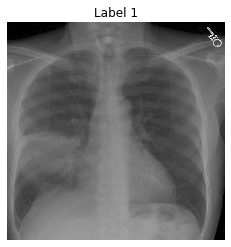

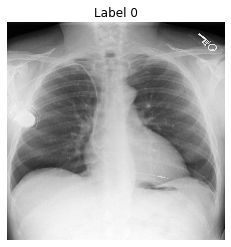

In [2]:
train_dataset = ImageDataset(train_data, random_labels=True)
test_dataset = ImageDataset(test_data, random_labels=True)

positives = filter(lambda x: x[1] == 1, train_data)
negatives = filter(lambda x: x[1] == 0, train_data)

plot_image(*next(positives))
plot_image(*next(negatives))

-----------Epoch 0------------
 Starting training loop
Running time -> 0:01:09
 Starting validation loop
Running time -> 0:00:06
Results
Train loss: 0.8254218085392101
Validation loss: 0.7882344283555683
Metric: 0.5087719298245613
Best metric achieved: 0.5087719298245613 -> Model saved
-----------Epoch 1------------
 Starting training loop
Running time -> 0:01:04
 Starting validation loop
Running time -> 0:00:06
Results
Train loss: 0.7155166171692513
Validation loss: 0.8748724899793926
Metric: 0.48464912280701755
-----------Epoch 2------------
 Starting training loop
Running time -> 0:01:07
 Starting validation loop
Running time -> 0:00:06
Results
Train loss: 0.7189817138620325
Validation loss: 0.7390142459618417
Metric: 0.5219298245614035
Best metric achieved: 0.5219298245614035 -> Model saved
-----------Epoch 3------------
 Starting training loop
Running time -> 0:01:07
 Starting validation loop
Running time -> 0:00:06
Results
Train loss: 0.7182357746201593
Validation loss: 0.6935294

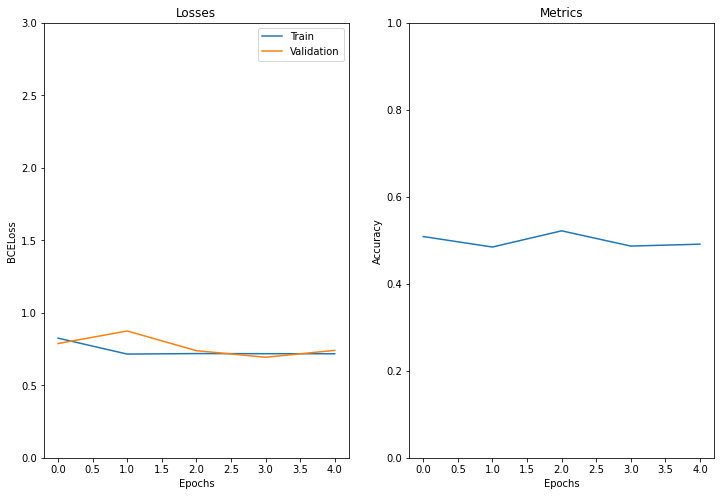

In [3]:
epochs = 5
batch_size = 16
lr = 1e-3

model = ImageClassifier(lr=lr, threshold=0.5, device="cuda:0", name="Random_Labels_Clasiffier")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size//2, shuffle=False)

train_manager = ClassifierTrainer(model=model, save_dir="./save_models")
train_manager.set_dataloaders(train_dataloader, test_dataloader)

def train_classifiers(train_manager: ClassifierTrainer, epochs: int) -> ClassifierTrainer:
    for epoch in range(epochs):
        print(f"Epoch {epoch}".center(30,"-"))
        print(" Starting training loop")
        train_manager.train_epoch()
        print(" Starting validation loop")
        train_manager.validation_epoch()
        print(f"Results")
        print(f"Train loss: {train_manager.epoch_train_loss[epoch]}")
        print(f"Validation loss: {train_manager.epoch_validation_loss[epoch]}")
        print(f"Metric: {train_manager.epoch_metric[epoch]}")
        train_manager.save_model()

    return train_manager

train_manager = train_classifiers(train_manager, epochs=5)
loss_fig = train_manager.plot_losses()


## 2. Images with and without added noise

In [4]:
train_noisy_data = generate_noisy_dataset(train_data)
test_noisy_data = generate_noisy_dataset(test_data)

train_noisy_dataset = ImageDataset(train_noisy_data, random_labels=False)
test_noisy_dataset = ImageDataset(test_noisy_data, random_labels=False)

epochs = 7
batch_size = 16
lr = 1e-3

model = ImageClassifier(lr=lr, threshold=0.5, device="cuda:0", name="Noisy_Images_Clasiffier")
train_dataloader = DataLoader(train_noisy_dataset, batch_size=batch_size, shuffle=True )
test_dataloader = DataLoader(test_noisy_dataset, batch_size=1, shuffle=False)

train_manager = ClassifierTrainer(model, save_dir="./save_models")
train_manager.set_dataloaders(train_dataloader, test_dataloader)
train_manager = train_classifiers(train_manager, epochs=epochs)
loss_fig = train_manager.plot_losses()

-----------Epoch 0------------
 Starting training loop
Running time -> 0:01:09
 Starting validation loop
Running time -> 0:00:09
Results
Train loss: 0.10594890798942337
Validation loss: 5.393081766764323
Metric: 0.49333333333333335
-----------Epoch 1------------
 Starting training loop
Running time -> 0:01:07
 Starting validation loop
Running time -> 0:00:08
Results
Train loss: 0.053568799482073284
Validation loss: 0.01662043283953068
Metric: 0.9933333333333333
-----------Epoch 2------------
 Starting training loop
Running time -> 0:01:09
 Starting validation loop
Running time -> 0:00:09
Results
Train loss: 0.067894894840523
Validation loss: 0.01601254859865558
Metric: 0.9933333333333333
-----------Epoch 3------------
 Starting training loop
Running time -> 0:01:09
 Starting validation loop
Running time -> 0:00:09
Results
Train loss: 0.041574367534406985
Validation loss: 0.49372662382227417
Metric: 0.7866666666666666
-----------Epoch 4------------
 Starting training loop
Running time -

## 3. Real and CycleGan Images

In [3]:
cyclegan_train_data = generate_cycle_gan_dataset(train_data)
cyclegan_train_dataset = CycleGanDataset(cyclegan_train_data)

epochs = 7
batch_size = 1
lr = 1e-3

model = CycleGan(device="cuda:0", lr=lr)
train_dataloader = DataLoader(cyclegan_train_dataset, batch_size=batch_size, shuffle=True)